<a href="https://colab.research.google.com/github/SleeplessCoder09/Machine-Learning-with-Python/blob/main/Stock_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

from pandas_datareader import data as pdr
import yfinance as yf  
import datetime

In [2]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [4]:
# # IMPORTING DATASET 
# dataset = pd.read_csv('SKX.csv', usecols=['Open','High','Low','Close'])
# print(dataset)
# # dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
# dataset = dataset.reindex(index = dataset.index[::-1])
# dataset = dataset[::-1]
# dataset
yf.pdr_override()
today = datetime.date.today()
print(today)
# data = yf.download('TSLA','2021-01-01',today)
data = yf.Ticker('TSLA').history(period='max')
data.head()
data.tail()
dataset = data[['Open','High','Low','Close']]
dataset = dataset.reindex(index = dataset.index[::-1])
dataset = dataset[::-1]
data.tail()

2023-05-17


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-10 00:00:00-04:00,172.550003,174.429993,166.679993,168.539993,119840700,0.0,0.0
2023-05-11 00:00:00-04:00,168.699997,173.570007,166.789993,172.080002,103889900,0.0,0.0
2023-05-12 00:00:00-04:00,176.070007,177.380005,167.229996,167.979996,157577100,0.0,0.0
2023-05-15 00:00:00-04:00,167.660004,169.759995,164.550003,166.350006,105592500,0.0,0.0
2023-05-16 00:00:00-04:00,165.649994,169.520004,164.350006,166.520004,96839500,0.0,0.0


In [5]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [6]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
OHLC_avg

Date
2010-06-29 00:00:00-04:00      1.423833
2010-06-30 00:00:00-04:00      1.722333
2010-07-01 00:00:00-04:00      1.552500
2010-07-02 00:00:00-04:00      1.400166
2010-07-06 00:00:00-04:00      1.199000
                                ...    
2023-05-10 00:00:00-04:00    170.549995
2023-05-11 00:00:00-04:00    170.285000
2023-05-12 00:00:00-04:00    172.165001
2023-05-15 00:00:00-04:00    167.080002
2023-05-16 00:00:00-04:00    166.510002
Length: 3243, dtype: float64

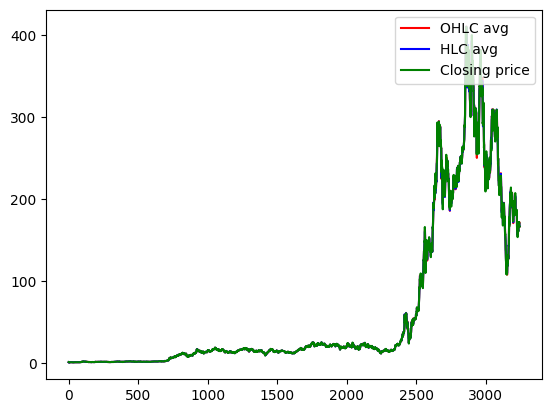

In [7]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [8]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 5))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [9]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.8)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [10]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [11]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [12]:
print(trainX)

[[0.00440142]
 [0.00804756]
 [0.00597307]
 ...
 [1.74307946]
 [1.79035097]
 [1.79429034]]


In [13]:
print(trainY)

[0.00804756 0.00597307 0.00411234 ... 1.79035097 1.79429034 1.84400478]


In [14]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [15]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
2592/2592 - 10s - loss: 0.0820 - 10s/epoch - 4ms/step
Epoch 2/50
2592/2592 - 6s - loss: 0.0711 - 6s/epoch - 2ms/step
Epoch 3/50
2592/2592 - 7s - loss: 0.0673 - 7s/epoch - 3ms/step
Epoch 4/50
2592/2592 - 6s - loss: 0.0652 - 6s/epoch - 2ms/step
Epoch 5/50
2592/2592 - 7s - loss: 0.0638 - 7s/epoch - 3ms/step
Epoch 6/50
2592/2592 - 6s - loss: 0.0627 - 6s/epoch - 2ms/step
Epoch 7/50
2592/2592 - 7s - loss: 0.0618 - 7s/epoch - 3ms/step
Epoch 8/50
2592/2592 - 6s - loss: 0.0610 - 6s/epoch - 2ms/step
Epoch 9/50
2592/2592 - 7s - loss: 0.0602 - 7s/epoch - 3ms/step
Epoch 10/50
2592/2592 - 6s - loss: 0.0595 - 6s/epoch - 2ms/step
Epoch 11/50
2592/2592 - 8s - loss: 0.0587 - 8s/epoch - 3ms/step
Epoch 12/50
2592/2592 - 7s - loss: 0.0580 - 7s/epoch - 3ms/step
Epoch 13/50
2592/2592 - 6s - loss: 0.0573 - 6s/epoch - 2ms/step
Epoch 14/50
2592/2592 - 8s - loss: 0.0566 - 8s/epoch - 3ms/step
Epoch 15/50
2592/2592 - 6s - loss: 0.0559 - 6s/epoch - 2ms/step
Epoch 16/50
2592/2592 - 7s - loss: 0.0551 - 7s/

In [ ]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# trainY = scaler.inverse_transform(trainY)
trainY

In [ ]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainY

In [ ]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

In [ ]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

In [ ]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [ ]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [ ]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

In [ ]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [ ]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))

In [ ]:
trainPredict

In [ ]:
# !pip install yfinance
from pandas_datareader import data as pdr
import yfinance as yf  
import matplotlib.pyplot as plt
yf.pdr_override()
data = yf.download('USHAMART.NS','2021-01-01','2023-05-13')
data.head()
data.tail()